## Motivation  
Quite often, ensemble models work considerably better than linear/logistic regession models.

However, while linear models provide a coefficient for each variable ,that can be easily translated to it's effect on the explained variable direction (i.e. - negative/positive coefficient suggests negative/positive correlation with the explained variable,respectively), ensemble models doesn't provide this type of information.

That's because trees can result different splits for the same variable - some can have positive (value larger than split point leads to higher outcome value) and others negative effect in different estimators (trees).

Thus, proposed here a new method. The method is applied on Random Forest model and provides the average effect on the outcome - the more negative/positive the resulted value, the more the negative/positive effect on the explained variable (the Outcome).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Directions function

In [2]:
def get_directions(orig_table_,outcome,model,n_sample):
    from collections import defaultdict
    
    X_test = orig_table_.drop(outcome,1).sample(n_sample) # Select N samples from the data
    orig_table = orig_table_.copy()  # Define the original Data frame:          

    # Get features names , as in the original Data Frame:
    feature_names = pd.Series(orig_table_.drop(outcome,1).columns)
    feature_names[-2] = None

    # Initialize dictionary, for each possible direction
    dict_signs = defaultdict(dict)
    for col in X_test.columns: 
        dict_signs[col]["<="] = []
        dict_signs[col][">"] = []
        
    for i,estimator in enumerate(model.estimators_): # For each tree in Forest
        leave_id = estimator.apply(X_test)
        # Take only one sample from each leaf. After calculating the delta contribution, multiply it by total samples number 
        mm = pd.Series(estimator.apply(X_test)).reset_index(name='leaf').groupby('leaf')['index'].agg({'f' : 'first','s':'size'})
        for ind, sample_id in enumerate(mm['f']):  # For each of the selected samples
            xt = orig_table.drop(outcome,1) 
            
            feature = estimator.tree_.feature
            threshold = estimator.tree_.threshold
            node_indicator = estimator.decision_path(X_test)
            

            # Get the nodes list of the given sample's path:
            node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                                node_indicator.indptr[sample_id + 1]]

            for node_id in node_index:
                if leave_id[sample_id] == node_id:
                    continue
                # For each split, calculates mean of outcome at left ("<=") and right (">") children.
                # Then , calculate: LEFT child's outcome mean outcome - previous mean & RIGHT child's outcome mean outcome - previous mean
                prev_mean = orig_table.loc[xt.index,outcome].mean()
        
                if (X_test.iloc[sample_id, feature[node_id]] <= threshold[node_id]):
                    threshold_sign = "<="
                    xt = xt[xt[feature_names[feature[node_id]]]<=threshold[node_id]]
                else:
                    threshold_sign = ">"
                    xt = xt[xt[feature_names[feature[node_id]]]>threshold[node_id]]
                
                new_mean = orig_table.loc[xt.index,outcome].mean()
                
                dict_signs[feature_names[feature[node_id]]][threshold_sign] += [new_mean - prev_mean]*mm.iloc[ind]['s']

    directions = pd.DataFrame(dict_signs).T.apply(lambda x: x.apply(lambda y: np.mean(y))).dropna()
    return  directions

In [3]:
f = pd.read_csv("diabetes.csv")

### Impute Zero values here: 

In [4]:
f_impute_zeros = f.copy()

In [5]:
for col in ['BMI','SkinThickness','BloodPressure','Glucose']:
    f_impute_zeros.loc[f_impute_zeros[col]==0,col] = f_impute_zeros.loc[f[col]>0,col].mean()
    #f = f[f[col]>0]

In [6]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

### Run "Rough" RandomForest model:

In [7]:
model=ensemble.RandomForestClassifier(min_samples_leaf=15,max_depth = 5,n_estimators=25)
outcome = 'Outcome'

model.fit(f_impute_zeros.drop(outcome,1),f_impute_zeros[outcome])
print (model.score(f_impute_zeros.drop(outcome,1),f_impute_zeros[outcome]))
print (roc_auc_score(f_impute_zeros[outcome] , model.predict_proba(f_impute_zeros.drop(outcome,1))[:,1]))

0.8033854166666666
0.8879776119402986


## Following decision path for each sample
The script below follows Random Forest's [Decision pathway](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html).

* Sample 150 samples which were modeled
* Follow the path for each sample, at each tree: 
    * Collect all splits conditions along the paths. 
 
* Divide the samples to class 1 and class 0.
* Get the mean values of '<=' splits and '>' splits - for each feature.



In [8]:
from collections import defaultdict

X_t = f_impute_zeros.sample(150) # Select 150 samples from the data
X_test = X_t.drop(outcome,1)
orig_table = f_impute_zeros.copy() # Define original table
outcome = 'Outcome'  # Define outcome 

feature_names = pd.Series(f_impute_zeros.drop(outcome,1).columns)
feature_names[-2] = None


dict_paths = {}
    
    
for sample_id in range(len(X_test)):  # For each of the selected samples
    dict_path_trees  = defaultdict(list)
    for i,estimator in enumerate(model.estimators_): # For each tree in Forest
        xt = orig_table.drop(outcome,1) 

        feature = estimator.tree_.feature
        threshold = estimator.tree_.threshold
        node_indicator = estimator.decision_path(X_test)

        # Similarly, we can also have the leaves ids reached by each sample.

        leave_id = estimator.apply(X_test)

        # Now, it's possible to get the tests that were used to predict a sample or
        # a group of samples. First, let's make it for the sample.

        node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                            node_indicator.indptr[sample_id + 1]]
        dict_path_tree  = defaultdict(list)
        #print('\n\n',sample_id,i)
        for node_id in node_index:
            if leave_id[sample_id] == node_id:
                continue

            if (X_test.iloc[sample_id, feature[node_id]] <= threshold[node_id]):
                threshold_sign = "<="
            else:
                threshold_sign = ">"
            #print (feature_names[feature[node_id]]+threshold_sign+str(threshold[node_id]))
            dict_path_tree[feature_names[feature[node_id]]+threshold_sign]+=[threshold[node_id]]
        for k,v in dict_path_tree.items():
            dict_path_trees[k]+=v
    dict_paths[sample_id] = dict_path_trees

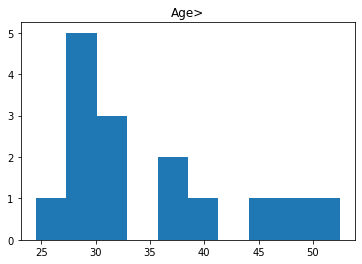

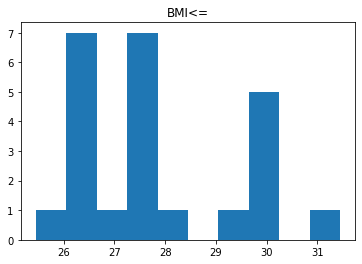

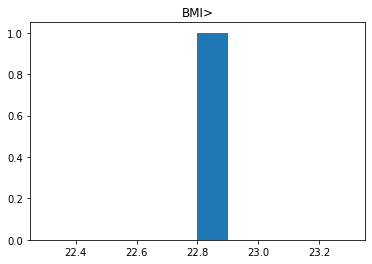

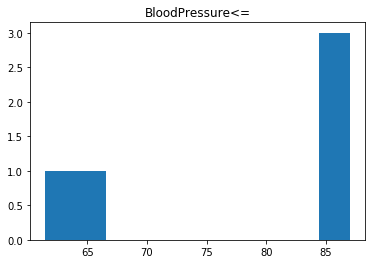

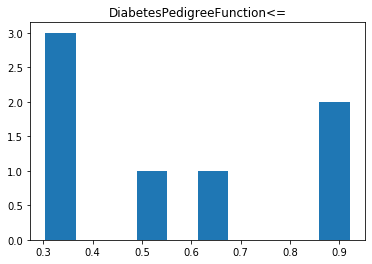

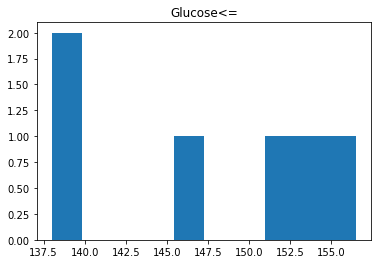

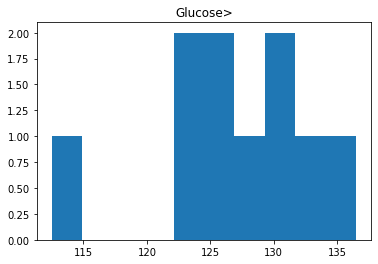

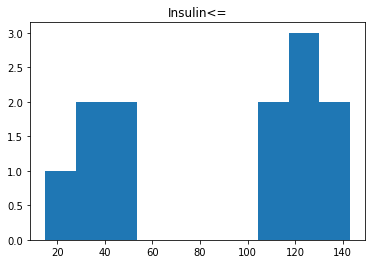

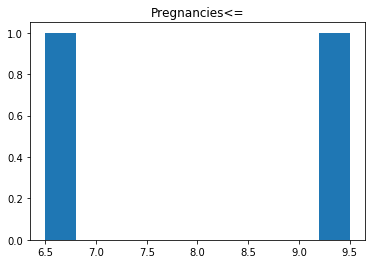

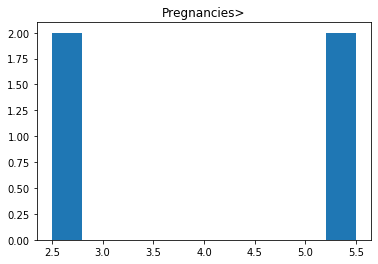

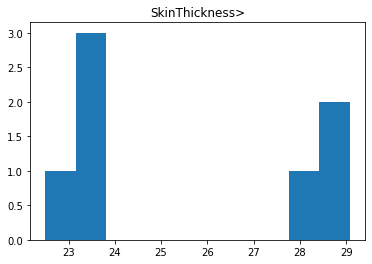

2     None
3     None
10    None
6     None
1     None
5     None
4     None
7     None
8     None
9     None
0     None
dtype: object

In [9]:
# Test for one value
def plt_hist(x,nam):
    plt.hist(x)
    plt.title(nam)
    plt.show()
pd.Series(dict_paths[0]).reset_index().sort_values('index').apply(lambda x: plt_hist(x[0],x['index']),axis=1)

#### In some cases, there's only '>' or '<=' , i.e. no upper/lower limit. This can explain why , for example , Age variable can have quite similar splits for '>' and '<=' : 
#### Additionally, in other cases, like in BloodPressure (samples 1-3), ranges for each sample are quite small and specific. Also here, unifying all the samples will not provide great value.

### Summary profile of 1 outcome Vs 0 outcome:

In [10]:
xt = X_t.reset_index()
one_indxs = xt[xt[outcome]==1].index

In [11]:
dict_paths_ones = defaultdict(list)
for x in one_indxs:
    for k,vl in dict_paths[x].items():
        dict_paths_ones[k]+=vl

In [12]:
xt = X_t.reset_index()
zero_indxs = xt[xt[outcome]==0].index


dict_paths_zero = defaultdict(list)
for x in zero_indxs:
    for k,vl in dict_paths[x].items():
        dict_paths_zero[k]+=vl
        
print ('mean 0: \n',pd.Series(dict_paths_zero).apply(np.mean).sort_index())
print ('mean 1: \n',pd.Series(dict_paths_ones).apply(np.mean).sort_index())

mean 0: 
 Age<=                          31.130285
Age>                           29.088640
BMI<=                          32.712821
BMI>                           28.261683
BloodPressure<=                78.713749
BloodPressure>                 66.808500
DiabetesPedigreeFunction<=      0.619301
DiabetesPedigreeFunction>       0.465952
Glucose<=                     133.329234
Glucose>                      121.487426
Insulin<=                     105.005155
Insulin>                       83.392606
Pregnancies<=                   5.425926
Pregnancies>                    3.258454
SkinThickness<=                27.698557
SkinThickness>                 25.347828
dtype: float64
mean 1: 
 Age<=                          35.322635
Age>                           28.957411
BMI<=                          36.288716
BMI>                           28.780761
BloodPressure<=                80.683483
BloodPressure>                 71.586117
DiabetesPedigreeFunction<=      0.636515
DiabetesPedigreeFuncti

In [13]:
f_impute_zeros1 = f_impute_zeros.copy()

## Segmentation by simple split:

###### Make sure that variables are avilable : model , feature_names (df.columns), f_impute_zeros (original df)

In [14]:
outcome = 'Outcome'

In [15]:
train,test = train_test_split(f_impute_zeros,test_size = 0.25)
mymodel=ensemble.RandomForestClassifier(min_samples_leaf=15,max_depth = 5,n_estimators=25)
mymodel.fit(train.drop(outcome,1),train[outcome])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
feature_names = pd.Series(train.drop(outcome,1).columns)
f_impute_zeros = train
model = mymodel

In [17]:
feature_names[-2] = None

all_splits = pd.DataFrame(index=feature_names)


for i,tt in enumerate(model.estimators_):
    pp = pd.DataFrame(index = ['feature','split_point'], data=[tt.tree_.feature,tt.tree_.threshold]).T
    pp['feature_name'] = pp['feature'].map(feature_names)
    pp['split_point'] = pp['split_point'].apply(lambda x: float("%.1f" %x))
    all_splits[i] = pp.groupby('feature_name').apply(lambda x: x.split_point.values)

aa = all_splits.T.apply(lambda x: list(np.hstack(x.values)))    
df_splits = pd.DataFrame(aa).T.apply(lambda x: pd.Series(x[0])).apply(lambda x: x.value_counts().to_dict())

In [18]:
def get_splits(x):
    x = pd.Series(x)
    his = np.histogram(x.dropna())
    h1 = pd.Series(index=his[0],data=his[1][1:].tolist()).reset_index().reset_index().sort_values('index',ascending = False)
    
    # Take highest 2 bars and determine their distance and height ratio, If they far and similar height - show both:
    diff_peak = (h1.iloc[:2,1].diff().abs().tolist()[1] / h1.iloc[1,1]) < 0.15
    dist_peak = h1.iloc[:2,0].diff().abs().tolist()[1] > 2
    
    if (diff_peak and dist_peak):
        return (h1[0].iloc[:2].values)
    else:
        return ([h1[0].iloc[0].tolist()])

In [19]:
# Use all frequent splits (more than one for a feature)
aa1 = aa.apply(get_splits)
aa2 = pd.melt( aa1.apply(lambda x: pd.Series(x)).reset_index(),id_vars = 'index').dropna()
aa2['var_combined']=aa2['index']+aa2['variable'].astype(str) 
ttt2 = pd.Series(index=aa2['var_combined'],data=aa2['value'].values)

In [20]:
f_imp = f_impute_zeros[aa2['index'].tolist()]
f_imp.columns = aa2['var_combined']
df_01 = pd.concat([(f_imp > ttt2).astype(int),f_impute_zeros[[outcome]]],1)

crrs = df_01.corr()[outcome].dropna().drop(outcome)
crrs = crrs.sort_values()
splits_pos = ttt2.loc[crrs[crrs > 0].index]
splits_neg = ttt2.loc[crrs[crrs < 0].index]

negs = f_imp[splits_neg.index] < splits_neg
poss = f_imp[splits_pos.index] > splits_pos

f_impute_zeros.loc[pd.concat([negs,poss],1).sum(1) >5,outcome].describe()

count    106.000000
mean       0.745283
std        0.437772
min        0.000000
25%        0.250000
50%        1.000000
75%        1.000000
max        1.000000
Name: Outcome, dtype: float64

In [21]:
roc_auc_score(y_score=pd.concat([negs,poss],1).sum(1),y_true=f_impute_zeros[outcome])

0.802576024798247

aa.apply(lambda x: pd.Series(x)).T.hist(figsize = (10,10))

In [22]:
aa1 = aa.apply(get_splits)
print (aa1)
ttt = aa1.apply(lambda x: x[0])

Pregnancies                                [7.1]
Glucose                           [145.8, 116.2]
BloodPressure                             [71.0]
SkinThickness                             [30.5]
Insulin                                  [35.95]
BMI                         [30.439999999999998]
DiabetesPedigreeFunction                  [0.58]
Age                                       [32.8]
NaN                                        [0.1]
dtype: object


In [23]:
df_01 = pd.concat([(f_impute_zeros.drop(outcome,1) > ttt).astype(int),f_impute_zeros[[outcome]]],1)
crrs = df_01.corr()[outcome].dropna().drop(outcome)
#crrs = crrs[crrs.abs().sort_values().iloc[int(len(crrs)/6):].index] 
### ** SELECT BEST VARIABLES - that covers 85% (define threshold) of total contribution to model
importants = pd.Series(index=f_impute_zeros.drop(outcome,1).columns,data=model.feature_importances_).sort_values(ascending = False)
importants = importants[importants.cumsum() <=0.95]
crrs = crrs.loc[importants.index]
crrs


Glucose                     0.422439
BMI                         0.285188
Age                         0.298073
DiabetesPedigreeFunction    0.158958
Pregnancies                 0.228795
Insulin                    -0.024217
Name: Outcome, dtype: float64

In [24]:
f_impute_zeros = test  #### Here we use test

splits_pos = ttt.loc[crrs[crrs > 0].index]
splits_neg = ttt.loc[crrs[crrs < 0].index]

negs = f_impute_zeros[splits_neg.index] < splits_neg
poss = f_impute_zeros[splits_pos.index] > splits_pos
f_impute_zeros.loc[pd.concat([negs,poss],1).sum(1) >2,outcome].describe()


count    79.000000
mean      0.506329
std       0.503155
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: Outcome, dtype: float64

In [25]:
splits_neg.apply(lambda x: '<' + str(x)).append(splits_pos.apply(lambda x: '>' + str(x)))

Insulin                                  <35.95
Glucose                                  >145.8
BMI                         >30.439999999999998
Age                                       >32.8
DiabetesPedigreeFunction                  >0.58
Pregnancies                                >7.1
dtype: object

In [26]:
roc_auc_score(y_true=f_impute_zeros[outcome],y_score=pd.concat([negs,poss],1).sum(1))

0.6965456674473068

In [27]:
roc_auc_score(y_true=f_impute_zeros[outcome],y_score=model.predict_proba(f_impute_zeros.drop(outcome,1))[:,1])

0.8117096018735364

#### Rough test for directions by split condition - all provide positive direction, thus - no need to changes directions (True to false or False to True)

In [28]:
fof = f_impute_zeros.drop(outcome,1).apply(lambda x: x > ttt[x.name])
simple_direction = pd.concat([fof,f_impute_zeros[[outcome]]],1).corr()['Outcome']
simple_direction

Pregnancies                 0.108752
Glucose                     0.357288
BloodPressure               0.127887
SkinThickness               0.109116
Insulin                    -0.051178
BMI                         0.236724
DiabetesPedigreeFunction    0.105300
Age                         0.163650
Outcome                     1.000000
Name: Outcome, dtype: float64

In [29]:
f_impute_zeros = f_impute_zeros1.copy()

## Segmentation by class 1 and class 0 paths  - 
### If feature direction is positive: Take upper split for zero-class and use it with upper sign ('>') to detect 1's.
### If feature direction is negative: Take lower split for zero-class and use it with lower sign ('<=') to detect 1's.
### Here, all features have positive direction : 

In [30]:
aa = pd.Series(dict_paths_zero).apply(np.mean).sort_index().reset_index(name='split_val')
aa['sign'] = aa['index'].apply(lambda x: '<=' if'<=' in x else '>')
aa['feature'] = aa['index'].str.replace('>','').str.replace('<=','')
zeros = aa.pivot_table(columns = 'feature',index = 'sign',values = 'split_val',aggfunc = 'sum')

In [31]:
dict_zero_lower = f_impute_zeros.drop(outcome,1).apply(lambda x: zeros[x.name].loc['<=']) #lower split
dict_zero_higher = f_impute_zeros.drop(outcome,1).apply(lambda x: zeros[x.name].loc['>']) # Upperl split

#### General case (positive and negative):

In [32]:
pos_direction = f_impute_zeros[dict_zero_higher[simple_direction > 0].index] > dict_zero_higher[simple_direction > 0]
neg_direction = f_impute_zeros[dict_zero_higher[simple_direction <= 0].index] <= dict_zero_higher[simple_direction <= 0]
gg = pd.concat([neg_direction,pos_direction],1) 
gg[outcome] = f_impute_zeros[outcome]
gg = gg[f_impute_zeros.drop(outcome,1).columns]

#### Only positive :

In [33]:
gg = f_impute_zeros > dict_zero_higher # Here, sign should be determined
                                       # for negative direction feature, use : gg = f_impute_zeros < dict_zero_lower 
gg[outcome] = f_impute_zeros[outcome]

In [34]:
kk = gg[gg[gg.columns[-7:]].drop(outcome,1).sum(1) <=3 ][outcome]
(sum(kk)/len(kk) , kk.std() , len(kk))

(0.20607375271149675, 0.4049234857739439, 461)

In [35]:
kk = gg[gg[gg.columns[-7:]].drop(outcome,1).sum(1) >3 ][outcome]
(sum(kk)/len(kk) , kk.std() , len(kk))

(0.5635179153094463, 0.4967587776524184, 307)

In [36]:
(gg[outcome].mean() , len(gg))

(0.3489583333333333, 768)

In [37]:
roc_auc_score(y_true=gg[outcome], y_score=gg.drop(outcome,1).sum(1).values)

0.7796529850746268

##### That's not much worse and way simpler..


### Directions

In [45]:
%%capture
directions = get_directions(orig_table_=f_impute_zeros.copy(),n_sample=150,outcome='Outcome',model=model)

In [46]:
directions.style.applymap(lambda x: 'color: red' if x<0 else  'color: green' )

,<=,>
Pregnancies,-0.0453103,0.0911722
Glucose,-0.110296,0.202584
BloodPressure,-0.0330694,0.0399704
SkinThickness,-0.0586794,0.0679243
Insulin,-0.0253911,0.0594376
BMI,-0.128354,0.0831138
DiabetesPedigreeFunction,-0.0596578,0.0710627
Age,-0.10701,0.123194


Finally, substract the '<=' direction  from '>' direction. For example, Glucose variable has strong positive/negative effect on the outcome when following a path towards higher/lower Glucose values. Hence, **Their subtraction will provide stronger estimate for the effect of each variable on the outcome's direction**

In [47]:
directions.T.diff().iloc[1]

Pregnancies                 0.136483
Glucose                     0.312880
BloodPressure               0.073040
SkinThickness               0.126604
Insulin                     0.084829
BMI                         0.211468
DiabetesPedigreeFunction    0.130721
Age                         0.230204
Name: >, dtype: float64

#### Compare directions with simple-splits (how much >/<= values correlated with 0/1)

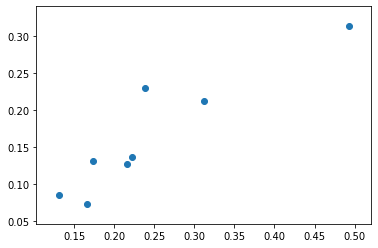

,l1,l2
l1,1.000000,0.917339
l2,0.917339,1.000000


In [51]:
l1= f_impute_zeros.corr()[outcome] 
l2= directions.T.diff().iloc[1]
ll = l1.reset_index(name='l1').set_index('index')
ll['l2'] = l2
plt.scatter(ll['l1'],ll['l2'])
plt.show()
ll.corr()

### All variables came fairly positive, which means - as value goes higher, it tends to correlate with higher outcome values

### Now, let's compare with logistic regression, which provides explicit coefficients:

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [53]:
# We'll standadize variables in order to get meaningful coefficients: 
model = make_pipeline(StandardScaler(), linear_model.LogisticRegression())

In [54]:
outcome = 'Outcome'

model.fit(f_impute_zeros.drop(outcome,1),f_impute_zeros[outcome])
print (model.score(f_impute_zeros.drop(outcome,1),f_impute_zeros[outcome]))
print (roc_auc_score(f_impute_zeros[outcome] , model.predict_proba(f_impute_zeros.drop(outcome,1))[:,1]))

0.7760416666666666
0.8463134328358208


/home/oz/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


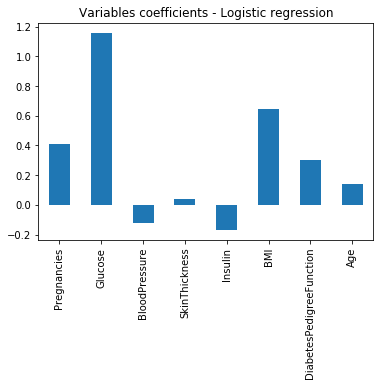

In [55]:
pd.Series(index=f_impute_zeros.drop(outcome,1).columns, data=model.steps[1][1].coef_[0]).plot(kind = 'bar')
plt.title('Variables coefficients - Logistic regression')
plt.show()

### Now, let's compare the "direction score" of random forest Vs logistic regression coefficients: 

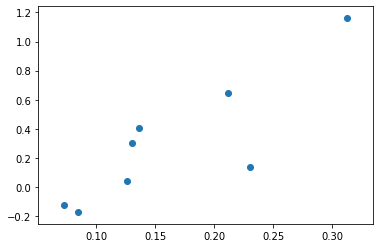

In [56]:
plt.scatter(directions.T.diff().iloc[1], model.steps[1][1].coef_[0])

In [57]:
pd.Series(index=directions.T.diff().iloc[1], data=model.steps[1][1].coef_[0]).reset_index().corr()

,>,0
>,1.000000,0.856864
0,0.856864,1.000000


In [58]:
ll =ll.drop(outcome)
ll['logreg'] = pd.Series(index=f_impute_zeros.drop(outcome,1).columns,data=model.steps[1][1].coef_[0])
ll.corr()

,l1,l2,logreg
l1,1.000000,0.917339,0.931709
l2,0.917339,1.000000,0.856864
logreg,0.931709,0.856864,1.000000


#### Fiarly correlated !

## Conclusions:
* We aimed to find a method that can produce equivalent to variables coefficients in logistic/linear regression
* For each variable, the suggested method maps the effect of each split on the outcome (higher/lower enrichment of the outcome)
* The method was applied on diabetes dataset and compared with logistic regression coefficients.
* Interestingly, the method was very correlated with the coefficients achieved by loistic regression. This implies for fairly linear correlations between the variables and the outcome. However, in cases of non-linear relations, it is expected that randomforests will produce very different results and will help to provide additional insights that could not be achieved by the linear models.